In [184]:
import json
import string
from nltk.corpus import stopwords
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [12,9]
from gensim.models import KeyedVectors
import word2vecReader as godin_embedding
import fasttext
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input,Dense,Flatten,Dropout,Embedding
from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.optimizers import Adam
from keras.layers.merge import concatenate
import keras.backend as K
from sklearn.model_selection import StratifiedKFold
from random import uniform,choice
from os import remove

In [185]:
def load_data(filename):
    with open(filename,'r') as fin:
        return json.load(fin)

In [186]:
dataset_dict = load_data("dataset/final_dataset.json")

In [187]:
def extract_data(dataset_dict):
    review = [dataset_dict[key]["review"] for key in dataset_dict.keys()]
    polarity = [dataset_dict[key]["polarity"] for key in dataset_dict.keys()]
    return review, polarity 

In [188]:
review, polarity = extract_data(dataset_dict)

In [218]:
# review = review[:100]
# polarity = polarity[:100]

In [190]:
len(review),len(polarity)

(100, 100)

In [191]:
def clean_sentence(sentence):
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    #for PYTHON 2.7
    #tokens = [w.translate(None, string.punctuation) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [192]:
review = [clean_sentence(s) for s in review]

In [193]:
length = [len(s) for s in review]

(array([ 2., 11., 22., 32., 15., 10.,  3.,  1.,  2.,  2.]),
 array([ 203. ,  879.5, 1556. , 2232.5, 2909. , 3585.5, 4262. , 4938.5,
        5615. , 6291.5, 6968. ]),
 <a list of 10 Patch objects>)

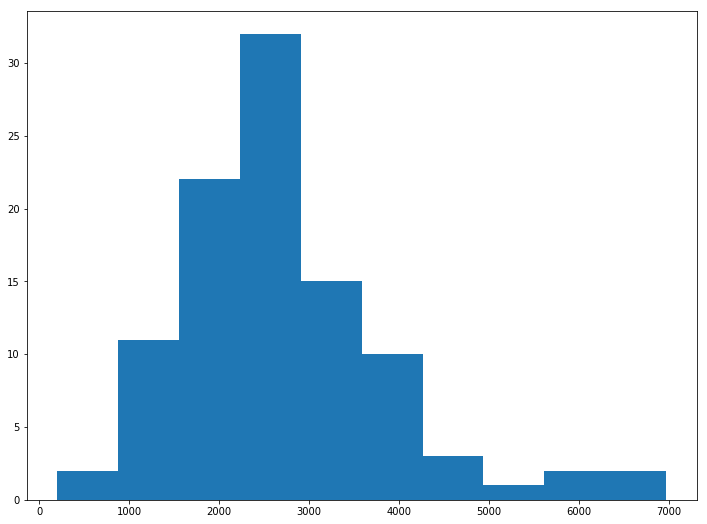

In [194]:
plt.hist(length)

In [195]:
max_len = 6500

In [196]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [197]:
def encode_text(tokenizer, lines, length):
    encoded = tokenizer.texts_to_sequences(lines)
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

In [198]:
#loading GloVe embedding
def load_GloVe_embedding(file_name):
    print('Loading GloVe word vectors.')
    embeddings_index = dict()
    f = open(file_name)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    return embeddings_index

In [199]:
# create a weight matrix for words in training docs
def get_GloVe_embedding_matrix(embeddings_index):
    embedding_matrix = np.zeros((vocab_size, 300))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [200]:
#fast text word embedding
def load_fast_text_model(sentences):
    try:
        m = fasttext.load_model('word_embeddings/fast_text_model.bin')
        print("trained model loaded")
        return m
    except:
        print("traning new model")
        with open('temp_file.txt','w') as temp_file:
            for sentence in sentences:
                temp_file.write(sentence)
        m = fasttext.cbow('temp_file.txt','word_embeddings/fast_text_model')
        remove('temp_file.txt')
        print('model trained')
        return m

In [201]:
def get_fast_text_matrix(model):
    embedding_matrix = np.zeros((vocab_size,100))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [202]:
#loading godin word embedding
def load_godin_word_embedding(path):
    print("Loading Goding model.")
    return godin_embedding.Word2Vec.load_word2vec_format(path, binary=True)

In [203]:
def get_godin_embedding_matrix(model):
    embedding_matrix = np.zeros((vocab_size,400))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [204]:
#loading Google Word2Vec
def load_google_word2vec(file_name):
    print("Loading google news word2vec")
    return KeyedVectors.load_word2vec_format(file_name, binary=True)

In [205]:
def get_word2vec_embedding_matrix(model):
    embedding_matrix = np.zeros((vocab_size,300))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [206]:
def define_model(length,vocab_size,n_dense,dropout,learning_rate,n_filters,filter_size_c1,filter_size_c2,filter_size_c3,em_c1,em_c2,em_c3,free_em_dim,em_trainable_flag_c1,em_trainable_flag_c2,em_trainable_flag_c3):
    # channel 1
    inputs1 = Input(shape=(length,))
    if em_c1 == 'free':
        embedding1 = Embedding(vocab_size, free_em_dim)(inputs1)
    else:
        embedding1 = Embedding(vocab_size, len(eval(em_c1)[0]), weights = [eval(em_c1)],input_length=length,trainable = em_trainable_flag_c1)(inputs1)
    
    conv1 = Conv1D(filters=n_filters, kernel_size=filter_size_c1, activation='relu')(embedding1)
    drop1 = Dropout(dropout)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # channel 2
    inputs2 = Input(shape=(length,))
    if em_c2 == 'free':
        embedding2 = Embedding(vocab_size, free_em_dim)(inputs2)
    else:
        embedding2 = Embedding(vocab_size, len(eval(em_c2)[0]), weights = [eval(em_c2)],input_length=length,trainable = em_trainable_flag_c2)(inputs2)
    conv2 = Conv1D(filters=n_filters, kernel_size=filter_size_c2, activation='relu')(embedding2)
    drop2 = Dropout(dropout)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # channel 3
    inputs3 = Input(shape=(length,))
    if em_c3 == 'free':
        embedding3 = Embedding(vocab_size, free_em_dim)(inputs3)
    else:
        embedding3 = Embedding(vocab_size, len(eval(em_c3)[0]), weights = [eval(em_c3)],input_length=length,trainable = em_trainable_flag_c3)(inputs3)
    conv3 = Conv1D(filters=n_filters, kernel_size=filter_size_c3, activation='relu')(embedding3)
    drop3 = Dropout(dropout)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(n_dense, activation='relu')(merged)
    outputs = Dense(2, activation='softmax')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    optimizer = Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    # summarize
#     print(model.summary())
    return model

In [207]:
X = review
Y = np.asarray(polarity)

In [208]:
tokenizer = create_tokenizer(X)
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % max_len)
print('Vocabulary size: %d' % vocab_size)
X = encode_text(tokenizer, X, max_len)

Max document length: 500
Vocabulary size: 10441


In [176]:
glove_model = load_GloVe_embedding('word_embeddings/glove.6B.300d.txt')
# fast_text_model = load_fast_text_model(review)
# godin_model = load_godin_word_embedding("word_embeddings/word2vec_twitter_model.bin")
# word2vec_model= load_google_word2vec('word_embeddings/GoogleNews-vectors-negative300.bin')

Loading GloVe word vectors.


In [177]:
embedding_matrix_glove = get_GloVe_embedding_matrix(glove_model)
# embedding_matrix_word2vec = get_word2vec_embedding_matrix(word2vec_model)
# embedding_matrix_fast_text = get_fast_text_matrix(fast_text_model)
# embedding_matrix_godin = get_godin_embedding_matrix(godin_model)

In [209]:
seed = 7
np.random.seed(seed)

In [210]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

In [211]:
def get_parameters():
    #range values
    para_n_dense = [100,200,300,400]
    para_n_filters = [100,200,300,400]
    para_filter_size = [1,2,3,4,5,6]
#     para_em = ['embedding_matrix_fast_text','embedding_matrix_godin','embedding_matrix_word2vec','embedding_matrix_glove','free']
    para_em = ['embedding_matrix_glove','free']
    para_free_em_dim = [100,300,400]
    para_em_trainable_flag = [True,False]
    para_batch_size = [8,16,32,64]
    para_epoc = [10,30,60,100]
#     para_epoc = [1]
#     para_batch_size = [8]
    #selecting_random_value
    parameters = {"n_dense": choice(para_n_dense),
            "dropout": uniform(0.4, 0.9),
            "learning_rate": uniform(0.0001, 0.1),
            "n_filters": choice(para_n_filters),
            "filter_size_c1": choice(para_n_filters),
            "filter_size_c2": choice(para_n_filters),
            "filter_size_c3": choice(para_n_filters),
            "em_c1": choice(para_em),
            "em_c2": choice(para_em),
            "em_c3": choice(para_em),
            "free_em_dim": choice(para_free_em_dim),
            "em_trainable_flag_c1": choice(para_em_trainable_flag),
            "em_trainable_flag_c2": choice(para_em_trainable_flag),
            "em_trainable_flag_c3": choice(para_em_trainable_flag),
            "batch": choice(para_batch_size),
            "epoch": choice(para_epoc)
        }
    return parameters

In [215]:
key = 1
record = {}

In [216]:
number_of_models = 2

In [217]:
for _ in range(number_of_models):
    itr = 1
    acc_record = []
    itr_record = {}
    parameters = get_parameters()
    print("model number {0}".format(key))
    for train,test in kfold.split(X,Y):
        print("k fold validation itr == {0}".format(itr))
        trainX = X[train]
        trainY = to_categorical(Y[train],num_classes=2)
        testX = X[test]
        testY = to_categorical(Y[test],num_classes=2)
        model = define_model(length = max_len,
                             vocab_size=vocab_size,
                             n_dense = parameters["n_dense"],
                             dropout = parameters["dropout"],
                             learning_rate = parameters["learning_rate"],
                             n_filters = parameters["n_filters"],
                             filter_size_c1 = parameters["filter_size_c1"],
                             filter_size_c2 = parameters["filter_size_c2"],
                             filter_size_c3 = parameters["filter_size_c3"],
                             em_c1 = parameters["em_c1"],
                             em_c2 = parameters["em_c1"],
                             em_c3 = parameters["em_c1"],
                             free_em_dim = parameters["free_em_dim"],
                             em_trainable_flag_c1 = parameters["em_trainable_flag_c1"],
                             em_trainable_flag_c2 = parameters["em_trainable_flag_c2"],
                             em_trainable_flag_c3 = parameters["em_trainable_flag_c3"])
        history = model.fit([trainX,trainX,trainX], trainY, validation_data = [[testX,testX,testX],testY],epochs=parameters["epoch"],batch_size=parameters["batch"])
        acc_record.append(history.history["val_acc"][0])
        itr_record[itr] = history.history["val_acc"][0]
        model.save('models/'+str(key)+'_'+str(itr)+'.h5')
        itr+=1
    record[key] = {}
    record[key]["parameter"] = parameters
    record[key]["mean_acc"] = np.mean(acc_record)
    record[key]["itr_record"] = itr_record

    with open("models/record.json",'w')as fout:
        json.dump(record,fout,indent=4)
    key+=1

model number 1
k fold validation itr == 1
Train on 50 samples, validate on 50 samples
Epoch 1/1
50/50 [==============================] - 107s 2s/step - loss: 7.1618 - acc: 0.5000 - val_loss: 7.6945 - val_acc: 0.5200
k fold validation itr == 2
Train on 50 samples, validate on 50 samples
Epoch 1/1
50/50 [==============================] - 103s 2s/step - loss: 7.4864 - acc: 0.4200 - val_loss: 8.3357 - val_acc: 0.4800
model number 2
k fold validation itr == 1
Train on 50 samples, validate on 50 samples
Epoch 1/1
50/50 [==============================] - 117s 2s/step - loss: 6.8453 - acc: 0.4800 - val_loss: 7.6945 - val_acc: 0.5200
k fold validation itr == 2
Train on 50 samples, validate on 50 samples
Epoch 1/1
50/50 [==============================] - 119s 2s/step - loss: 7.4843 - acc: 0.4800 - val_loss: 8.3357 - val_acc: 0.4800
